In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:

train_path='./fishing_logs.csv'
pred_path='./prediction_logs.csv'
if not (os.path.exists(train_path) and os.path.exists(pred_path)):
    train_path='/mnt/data/fishing_logs.csv'
    pred_path='/mnt/data/prediction_logs.csv'
train_df=pd.read_csv(train_path)
pred_df=pd.read_csv(pred_path)
display(train_df.head()); display(pred_df.head())


,Unnamed: 0,Water Temperature (°C),Depth Pressure (kPa),Temp-Pressure Index,Fish Activity Metric,Catch Density Metric,Catch Quality Rating
0,0,20.976270,80.508554,16.887692,44.522217,922.957596,0.100000
1,1,24.303787,158.120684,38.429315,63.020765,1435.536716,0.099986
2,2,22.055268,78.431300,17.298233,49.125950,1072.838869,0.100000
3,3,20.897664,237.860892,49.707369,57.128882,912.570195,0.100000
4,4,18.473096,157.978122,29.183450,38.068201,630.379189,0.100000


,Unnamed: 0.1,Unnamed: 0,Water Temperature (°C),Depth Pressure (kPa),Temp-Pressure Index,Fish Activity Metric,Catch Density Metric
0,0,2500,27.026469,110.237627,29.793338,74.382646,1974.082242
1,1,2501,14.711344,248.518987,36.560483,36.991316,318.326504
2,2,2502,25.163669,198.619833,49.980038,71.156546,1593.349908
3,3,2503,22.676502,233.012270,52.839033,64.073711,1166.025319
4,4,2504,29.102521,168.968947,49.174223,89.519820,2464.828968


In [8]:

def preprocess(df, mean=None, std=None, fit=False):
    df=df.copy()
    drop_cols=[c for c in df.columns if 'Unnamed' in c]
    df=df.drop(columns=drop_cols)
    y=None
    if 'Catch Quality Rating' in df.columns:
        y=df['Catch Quality Rating'].values
        df=df.drop(columns=['Catch Quality Rating'])
    X=df.values.astype(float)
    if fit:
        mean=X.mean(axis=0); std=X.std(axis=0); std[std==0]=1
    X=(X-mean)/std
    X=np.hstack([np.ones((len(X),1)),X])
    return X,y,mean,std


In [9]:

class RidgeRegressionGD:
    def __init__(self,n_features,lr=0.01,lmbda=0.1):
        self.W=np.zeros(n_features)
        self.lr=lr; self.lmbda=lmbda
    def predict(self,X): return X.dot(self.W)
    def cost(self,X,y):
        m=len(y)
        pred=self.predict(X)
        return (1/(2*m))*np.sum((pred-y)**2)+self.lmbda*np.sum(self.W[1:]**2)
    def grad(self,X,y):
        m=len(y)
        pred=self.predict(X)
        g=(1/m)*X.T.dot(pred-y)
        g[1:]+=2*self.lmbda*self.W[1:]
        return g
    def fit(self,X,y,epochs=300,print_every=50):
        hist=[]
        for e in range(1,epochs+1):
            self.W-=self.lr*self.grad(X,y)
            c=self.cost(X,y); hist.append(c)
            if e%print_every==0 or e==1 or e==epochs:
                print(f"Epoch {e} Cost={c:.4f}")
        return hist


Epoch 1 Cost=0.0046
Epoch 50 Cost=0.0018
Epoch 100 Cost=0.0007
Epoch 150 Cost=0.0003
Epoch 200 Cost=0.0001
Epoch 250 Cost=0.0001
Epoch 300 Cost=0.0001
Saved catch_quality_predictions.csv


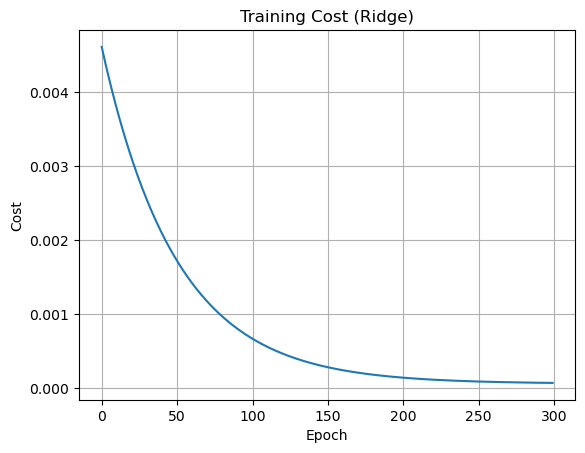

In [10]:

X_train,y_train,mean,std=preprocess(train_df,fit=True)
model=RidgeRegressionGD(n_features=X_train.shape[1],lr=0.01,lmbda=0.1)
hist=model.fit(X_train,y_train,epochs=300)

plt.plot(hist); plt.title("Training Cost (Ridge)"); plt.xlabel("Epoch"); plt.ylabel("Cost"); plt.grid(True)

X_pred,_,_,_=preprocess(pred_df,mean,std,fit=False)
preds=model.predict(X_pred)

out=pd.DataFrame({'predicted_quality':preds})
out.to_csv('catch_quality_predictions.csv',index=False)
print("Saved catch_quality_predictions.csv")
